In [1]:
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (295 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.1-

In [2]:
!pip install transformers

     |████████████████████████████████| 665kB 3.5MB/s 
     |████████████████████████████████| 890kB 17.1MB/s 
     |████████████████████████████████| 1.1MB 15.5MB/s 
     |████████████████████████████████| 3.8MB 34.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=7f390abb1e2dfe03c47213acc1827a64d5351e99979805e50e3ca076f65f6bff
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import faiss

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/'My Drive'/UniversalEmb

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/UniversalEmb


In [5]:
%cd Question_augmentation 

/content/drive/My Drive/UniversalEmb/Question_augmentation


In [6]:
!ls ../

 augm_emb.npy
 bert_2500_squad_055.csv
 BoolQ_Dataset_dev.jsonl
 BoolQ_Dataset_train.jsonl
 bpe_emv.vec
 bpe_emv.vec.pt
 crawl-300d-2M.vec
 crawl-300d-2M.vec.zip
 dev.jsonl
 dev.txt
 eda_nlp
'open?id=0BwmD_VLjROrfTTljRDVZMFJnVWM'
 Question_augmentation
 SQuAD_emb.npy
 SST
 sst2-splited
 stsa.binary.train
 test.csv
 test.tsv
 test.txt
 train_5500.label
 train_bert_emb3k.npy
 train_bert_emb4k.npy
 train_bert_emb.npy
 train.csv
 train_emb.npy
 train.jsonl
 train.tsv
 train.txt
 train-v2.0.json
 TREC_10.label
 trec-50_clear_3000_samples.txt
 trec-50_clear_4000_samples.txt
 trec-50_clear_5000_samples.txt
 TREC50_Dataset_random_with_same_n_classes_Model_number_3_Bert_#0_squad_0.7.csv
 TREC50_Dataset_random_with_same_n_classes_Model_number_3_Bert_#1_squad_0.7.csv
 TREC50_Dataset_random_with_same_n_classes_Model_number_3_Bert_#2_squad_0.7.csv
 trec-50_eda_aug_3000_samples.txt
 trec-50_eda_aug_4000_samples.txt
 trec-50_eda_aug_5000_samples.txt
 trec50_n1_bert_0_boolq_075_with_min_max_distance.c

In [7]:
import torch
torch.manual_seed(0)
import numpy as np
np.random.seed(0)

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
import transformers
from transformers import AdamW
from torch import nn
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
def read_trec50(file_name, typ=1):
  train = pd.read_csv(file_name, index_col=0)
  lbl2indx = {i:j for j, i in enumerate(train.labels.unique())}
  train.columns = ['text', 'labels']
  train['lbl_index'] = train.labels.apply(lambda x:lbl2indx[x])
  labels_t = [i.split(' ', 1)[0].split(':')[typ] for i in open('../TREC_10.label', encoding = 'windows-1252').readlines()]
  texts_t = [ i.split(' ', 1)[1][:-1] for i in open('../TREC_10.label', encoding = 'windows-1252').readlines()]
  test  = pd.DataFrame({'text':texts_t, 'labels': labels_t})
  test['lbl_index'] = test.labels.apply(lambda x:lbl2indx[x])

  return train, test, lbl2indx

train, test, l2i = read_trec50('../trec50_splited/trec50_5k.csv')

In [0]:
import pandas as pd
def read_trec6(file_name, typ=0):
  train = pd.read_csv(file_name, index_col=0)
  lbl2indx = {i:j for j, i in enumerate(train.labels.unique())}
  train.columns = ['text', 'labels']
  train['lbl_index'] = train.labels.apply(lambda x:lbl2indx[x])


  labels_t = [i.split(' ', 1)[0].split(':')[typ] for i in open('../TREC_10.label', encoding = 'windows-1252').readlines()]
  texts_t = [ i.split(' ', 1)[1][:-1] for i in open('../TREC_10.label', encoding = 'windows-1252').readlines()]
  test  = pd.DataFrame({'text':texts_t, 'labels': labels_t})
  test['lbl_index'] = test.labels.apply(lambda x:lbl2indx[x])

  return train, test, lbl2indx
train, test, l2i = read_trec6('../trec6_splited/trec6_splited_4k.csv')

In [0]:
!ls ../trec6_splited

augmented_with_eda  trec6_splited_3k.csv  trec6_splited_5k.csv
prepared_for_eda    trec6_splited_4k.csv


искать примеры только к тренировочным примерам которые являются цетром категории 

In [0]:
MAX_SEQ_LEN = 64
BATCH_SIZE = 128
pretrained_weights = 'bert-base-cased'

## Train 4 BertLSTM

In [0]:

def prep_data(sentences, tokenizer, MAX_LEN = MAX_SEQ_LEN):
  filtred_by_len =[]
  input_ids = []
  s=0
  for sent in sentences:
      encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
      if len(encoded_sent) <= MAX_LEN:
        input_ids.append(encoded_sent)
        filtred_by_len.append(sent)
      else:
        s+=1
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
  attention_masks = []
  for sent in input_ids:
      att_mask = [int(token_id > 0) for token_id in sent]
      attention_masks.append(att_mask)
  print("Not used sentence because it bpe len > {} : {}".format(MAX_LEN, s))
  return input_ids, attention_masks, filtred_by_len

In [0]:
class BertEmbeddingLayer(torch.nn.Module):

    def __init__(self, embedding_layer, padding_idx=0):
        super().__init__()

        self.embedding_layer = embedding_layer
        self.padding_idx = padding_idx

    def forward(self, x):

        embed = self.embedding_layer(x)

        pad_mask = x != self.padding_idx
        pad_mask = pad_mask.unsqueeze(-1).repeat(1, 1, embed.size(-1)).float()

        embed = embed * pad_mask

        return embed

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

import keras.backend as K
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

class BertEmbdLSTMPooling(torch.nn.Module):
  def __init__(self, n_class, b_e):
    super(BertEmbdLSTMPooling, self).__init__()
    self.embed = BertEmbeddingLayer(embedding_layer=b_e , padding_idx=0)
    self.lstm = nn.LSTM(768, 256, num_layers=1,  bidirectional=True, dropout=0.35,batch_first = True)
    self.linear = nn.Linear(512, n_class)

  def forward(self, x):
    x = self.embed(x)
    #print(x.shape)
    x, _ = self.lstm(x)
    #print(x.shape)

    value, indx = torch.max(x, dim = 1)
    #print(value.shape)
    return self.linear(value)

In [0]:
def train_BertEmbdLSTMPooling(train, test):  
  tokenizer_ = transformers.BertTokenizer.from_pretrained(pretrained_weights)
  bert_emb_ = transformers.BertModel.from_pretrained(pretrained_weights).embeddings

  train_input_ids, train_attention_masks, filtred_train = prep_data(train.text.values.tolist(), tokenizer_)
  test_input_ids, test_attention_masks,filtred_test = prep_data(test.text.values.tolist(), tokenizer_)
  train_inputs = torch.tensor(train_input_ids)
  validation_inputs = torch.tensor(test_input_ids)

  train_labels = torch.tensor(train.lbl_index.values.tolist())
  validation_labels = torch.tensor(test.lbl_index.values.tolist())

  train_masks = torch.tensor(train_attention_masks)
  validation_masks = torch.tensor(test_attention_masks)

  batch_size = BATCH_SIZE

  # Create the DataLoader for our training set.
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  print("Training example : {}".format(len(train_data)))
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # Create the DataLoader for our validation set.
  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  print("Valid example : {}".format(len(validation_data)))
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  model = BertEmbdLSTMPooling(len(train.lbl_index.unique()), bert_emb_)

  # Tell pytorch to run this model on the GPU.
  device = 'cuda'
  model = model.cuda()

  epochs = 7
  total_steps = len(train_dataloader) * epochs

  lf = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=0, reduce=None, reduction='mean')
  optimizer = AdamW(model.parameters(), lr = 0.001, eps=1e-07)
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 10, # Default value in run_glue.py
                                              num_training_steps = total_steps)

  loss_values = []
  best_model = None
  best_f1 = 0

  for epoch_i in range(0, epochs):
      embeddings = []
      best_metrics = {'acc':[], 'f':[]}

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')
      t0 = time.time()
      total_loss = 0
      model.train()

      for step, batch in enumerate(train_dataloader):
          if step % 100 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
          b_input_ids = batch[0].to(device)
          
          b_labels = batch[2].to(device)
          model.zero_grad()        

          outputs = model(b_input_ids)
          loss = lf(outputs, b_labels)
          total_loss += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
          scheduler.step()

      avg_train_loss = total_loss / len(train_dataloader)            
      loss_values.append(avg_train_loss)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
          
      print("")
      print("Running Validation...")

      t0 = time.time()
      test_targets, test_pred_class = [], []

      model.eval()

      eval_loss, eval_accuracy = 0, 0
      nb_eval_steps, nb_eval_examples = 0, 0

      for batch in validation_dataloader:
          
          batch = tuple(t.to(device) for t in batch)
          
          b_input_ids, b_input_mask, b_labels = batch
          with torch.no_grad():        
              logits = model(b_input_ids)

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          test_targets.append(label_ids)
          test_pred_class.append(np.argmax(logits, axis=1))
          
          # Calculate the accuracy for this batch of test sentences.
          tmp_eval_accuracy = flat_accuracy(logits, label_ids)
          
          # Accumulate the total accuracy.
          eval_accuracy += tmp_eval_accuracy

          nb_eval_steps += 1
      test_targets = np.concatenate(test_targets).squeeze()
      test_pred_class = np.concatenate(test_pred_class).squeeze()

      acc = accuracy_score(test_targets, test_pred_class)
      f1 = f1_score(test_targets, test_pred_class, average='weighted')

      if f1 > best_f1:
        best_f1 = f1
        best_model = model

      best_metrics['acc'].append(acc)

      # Report the final accuracy for this validation run.
      print("  Accuracy: {0:.5f}".format(acc))
      print("  F1: {0:.5f}".format(f1))
      print("  Validation took: {:}".format(format_time(time.time() - t0)))

  print("")
  print("Training complete!")
  print( "Accuracy: {}, F1:{}".format(max(best_metrics['acc']), best_f1))
  return max(best_metrics['acc']), best_f1, model

In [0]:
f1_scores, acc_scores, models = [], [], []
for _ in range(3):
  acccur, f1_sc, model = train_BertEmbdLSTMPooling(train, test)
  f1_scores.append(f1_sc)
  acc_scores.append(acccur)
  models.append(model)
  print('\n\n')
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Not used sentence because it bpe len > 64 : 0
Not used sentence because it bpe len > 64 : 0
Training example : 4004
Valid example : 500

======== Epoch 1 / 7 ========
Training...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.35 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



  Average training loss: 1.11
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.57400
  F1: 0.52378
  Validation took: 0:00:00

======== Epoch 2 / 7 ========
Training...

  Average training loss: 0.27
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.65600
  F1: 0.58816
  Validation took: 0:00:00

======== Epoch 3 / 7 ========
Training...

  Average training loss: 0.05
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.67400
  F1: 0.59689
  Validation took: 0:00:00

======== Epoch 4 / 7 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66800
  F1: 0.59173
  Validation took: 0:00:00

======== Epoch 5 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.67400
  F1: 0.59369
  Validation took: 0:00:00

======== Epoch 6 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0

In [0]:
test

,text,labels,lbl_index
0,How far is it from Denver to Aspen ?,NUM,4
1,"What county is Modesto , California in ?",LOC,5
2,Who was Galileo ?,HUM,3
3,What is an atom ?,DESC,0
4,When did Hawaii become a state ?,NUM,4
...,...,...,...
495,Who was the 22nd President of the US ?,HUM,3
496,What is the money they use in Zambia ?,ENTY,1
497,How many feet in a mile ?,NUM,4
498,What is the birthstone of October ?,ENTY,1


In [0]:
models[0]

BertEmbdLSTMPooling(
  (embed): BertEmbeddingLayer(
    (embedding_layer): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (lstm): LSTM(768, 256, batch_first=True, dropout=0.35, bidirectional=True)
  (linear): Linear(in_features=512, out_features=6, bias=True)
)

In [0]:
def USE_Embeder(input):
  module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
  model = hub.load(module_url)
  return model(input)

In [0]:
def get_k_near_neibs(train_vectors, augmented_vectors, k=5):  
  res = faiss.StandardGpuResources()  
  index_flat = faiss.IndexFlatL2(train_vectors.shape[1])
  gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
  gpu_index_flat.add(augmented_vectors)         # add vectors to the index
  D, I = gpu_index_flat.search(train_vectors, k)
  print("Number of neibs : {}".format(I.shape[0]*I.shape[1])) 
  return D,I

In [0]:
def filter_samples_by_dist(distances, indices, augs):
  mask_for_ind = np.where(distances < 0.9, 1, -1)
  filtred_ind = np.multiply(indices, mask_for_ind)
  print(filtred_ind)
  augmented_text = []
  augmented_lbl_index = []
  for row, lbl  in zip(filtred_ind, train['lbl_index'].tolist()):
    for ind in row:
      if ind > -1:
        augmented_text.append(augs[ind])
        augmented_lbl_index.append(lbl)
  print('Number of samples after filting by distance : {}'.format(len(augmented_text)))
  return augmented_text, augmented_lbl_index

In [0]:
def indxs_to_dataframe(augmented_indexs, sentences):
  return pd.DataFrame({"text":[sentences[i] for i, j in augmented_indexs], "lbl_index":[j for i, j in augmented_indexs]}).drop_duplicates()

In [0]:
from torch import nn
from tqdm import tqdm
def bert_proba(boundary, model, sentences):
  batch_size = BATCH_SIZE
  device = "cuda"
  tokenizer_ = transformers.BertTokenizer.from_pretrained(pretrained_weights)

  train_input_ids, train_attention_masks, sent_filtred_by_len = prep_data(sentences, tokenizer_, MAX_SEQ_LEN)

  train_inputs = torch.tensor(train_input_ids)
  train_labels = torch.tensor([0]*len(sent_filtred_by_len))
  train_masks = torch.tensor(train_attention_masks)
  
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  print("Number of sentence augmentations : {}".format(len(train_data)))
  train_dataloader = DataLoader(train_data, shuffle=False, batch_size=batch_size)

  model.eval()
  augmentations = []
  for batch in tqdm(train_dataloader):
      
      batch = tuple(t.to(device) for t in batch)
      
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():        
              logits = model(b_input_ids)
      probs = nn.Softmax(dim=-1)(logits)

      probs = probs.detach().cpu().numpy()
      samples = []
      for indx, i in enumerate(probs.tolist()):
        if any(boundary < y for y in i):
          samples.append((indx, i.index(max(i))))
      augmentations.append(samples)
   
  aug_samples_indx = []
  for ind, i in enumerate(augmentations):
    if ind==0:
      aug_samples_indx.extend([(j,k) for j,k in i])
    else:
      aug_samples_indx.extend([((batch_size*ind)+j, k) for j,k in i])
  print()
  print('Number of augmented samples by Model: {}'.format(len(aug_samples_indx)))
  
  return indxs_to_dataframe(aug_samples_indx, sent_filtred_by_len)

In [0]:
all_augment_questions = [i[:-1] for i in open('multi_amazon_questions_cleared.txt').readlines()] + [i[:-1] for i in open('SQuAD.txt').readlines()]
train_vectors = USE_Embeder(train['text']).numpy()

####### NEW PART Of DATA ###########
Number of neibs : 8008
[[-14172  -1621]
 [ -5543 -16945]
 [ 14846 -16151]
 ...
 [-10609 -18049]
 [-10298 -23360]
 [  -960  -6347]]
Number of samples after filting by distance : 815
Index of model to train: 0, Current F1 Score :0.5968922018368837
Eval examples by model #1


100%|██████████| 7/7 [00:00<00:00, 41.04it/s]

Not used sentence because it bpe len > 64 : 0
Number of sentence augmentations : 815

Number of augmented samples by Model: 758
Eval examples by model #2



100%|██████████| 7/7 [00:00<00:00, 41.36it/s]

Not used sentence because it bpe len > 64 : 0
Number of sentence augmentations : 815

Number of augmented samples by Model: 767
                                                text  lbl_index
0  Is there an untimed mode ? Can it be used as a...          1
1                                what is damations ?          1
2                                  what is spirulina          1
3  Do u think this would work well as a tennis ba...          1
4                              how is it on carpet ?          4 (422, 2)


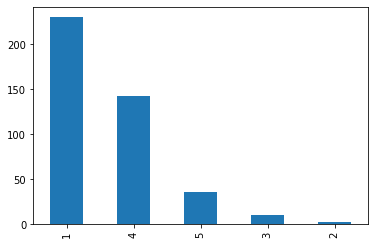

Not used sentence because it bpe len > 64 : 0
Not used sentence because it bpe len > 64 : 0
Training example : 4426
Valid example : 500

======== Epoch 1 / 7 ========
Training...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.35 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



  Average training loss: 1.02
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.61000
  F1: 0.54316
  Validation took: 0:00:00

======== Epoch 2 / 7 ========
Training...

  Average training loss: 0.22
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66400
  F1: 0.58653
  Validation took: 0:00:00

======== Epoch 3 / 7 ========
Training...

  Average training loss: 0.04
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.65800
  F1: 0.58476
  Validation took: 0:00:00

======== Epoch 4 / 7 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66600
  F1: 0.58857
  Validation took: 0:00:00

======== Epoch 5 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66000
  F1: 0.57985
  Validation took: 0:00:00

======== Epoch 6 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0

100%|██████████| 7/7 [00:00<00:00, 43.78it/s]

Not used sentence because it bpe len > 64 : 0
Number of sentence augmentations : 815

Number of augmented samples by Model: 748
Eval examples by model #2



100%|██████████| 7/7 [00:00<00:00, 44.90it/s]

Not used sentence because it bpe len > 64 : 0
Number of sentence augmentations : 815

Number of augmented samples by Model: 767
                                                text  lbl_index
0  Is there an untimed mode ? Can it be used as a...          1
1                                what is damations ?          1
2  Do u think this would work well as a tennis ba...          1
3                              how is it on carpet ?          4
4  Can you use these tiles on carpet without dama...          1 (430, 2)


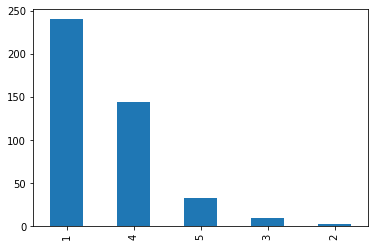

Not used sentence because it bpe len > 64 : 0
Not used sentence because it bpe len > 64 : 0
Training example : 4434
Valid example : 500

======== Epoch 1 / 7 ========
Training...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.35 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



  Average training loss: 1.00
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.63400
  F1: 0.56240
  Validation took: 0:00:00

======== Epoch 2 / 7 ========
Training...

  Average training loss: 0.20
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.65400
  F1: 0.56408
  Validation took: 0:00:00

======== Epoch 3 / 7 ========
Training...

  Average training loss: 0.03
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66400
  F1: 0.58353
  Validation took: 0:00:00

======== Epoch 4 / 7 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66000
  F1: 0.57968
  Validation took: 0:00:00

======== Epoch 5 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66600
  F1: 0.58776
  Validation took: 0:00:00

======== Epoch 6 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0

100%|██████████| 7/7 [00:00<00:00, 43.72it/s]

Not used sentence because it bpe len > 64 : 0
Number of sentence augmentations : 815

Number of augmented samples by Model: 748
Eval examples by model #1



100%|██████████| 7/7 [00:00<00:00, 45.46it/s]

Not used sentence because it bpe len > 64 : 0
Number of sentence augmentations : 815

Number of augmented samples by Model: 758
                                                text  lbl_index
0  Is there an untimed mode ? Can it be used as a...          1
1                                what is damations ?          1
2  Do u think this would work well as a tennis ba...          1
3                              how is it on carpet ?          4
4  Can you use these tiles on carpet without dama...          1 (420, 2)


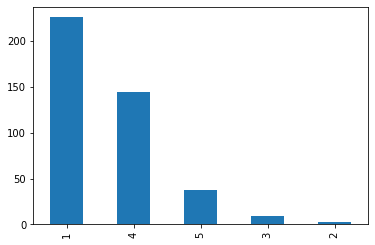

Not used sentence because it bpe len > 64 : 0
Not used sentence because it bpe len > 64 : 0
Training example : 4424
Valid example : 500

======== Epoch 1 / 7 ========
Training...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.35 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



  Average training loss: 1.02
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.58400
  F1: 0.52740
  Validation took: 0:00:00

======== Epoch 2 / 7 ========
Training...

  Average training loss: 0.23
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66800
  F1: 0.59502
  Validation took: 0:00:00

======== Epoch 3 / 7 ========
Training...

  Average training loss: 0.04
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.67200
  F1: 0.59525
  Validation took: 0:00:00

======== Epoch 4 / 7 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.67200
  F1: 0.59421
  Validation took: 0:00:00

======== Epoch 5 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66400
  F1: 0.58520
  Validation took: 0:00:00

======== Epoch 6 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0

100%|██████████| 7/7 [00:00<00:00, 41.27it/s]

Not used sentence because it bpe len > 64 : 0
Number of sentence augmentations : 775

Number of augmented samples by Model: 711
Eval examples by model #2



100%|██████████| 7/7 [00:00<00:00, 40.52it/s]

Not used sentence because it bpe len > 64 : 0
Number of sentence augmentations : 775

Number of augmented samples by Model: 733
                                  text  lbl_index
0                 what is " Stelvio "?          1
1           what is obagi action for ?          1
2              What are the deminsions          1
3  can i put it on top of the carpet ?          1
4               does it work on carpet          1 (398, 2)


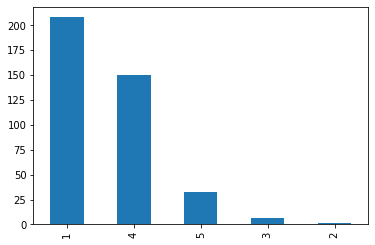

Not used sentence because it bpe len > 64 : 0
Not used sentence because it bpe len > 64 : 0
Training example : 4822
Valid example : 500

======== Epoch 1 / 7 ========
Training...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.35 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



  Average training loss: 0.95
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.61400
  F1: 0.55006
  Validation took: 0:00:00

======== Epoch 2 / 7 ========
Training...

  Average training loss: 0.19
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.65600
  F1: 0.58618
  Validation took: 0:00:00

======== Epoch 3 / 7 ========
Training...

  Average training loss: 0.03
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.67400
  F1: 0.59530
  Validation took: 0:00:00

======== Epoch 4 / 7 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.67400
  F1: 0.59261
  Validation took: 0:00:00

======== Epoch 5 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66400
  F1: 0.58204
  Validation took: 0:00:00

======== Epoch 6 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0

100%|██████████| 7/7 [00:00<00:00, 46.19it/s]

Not used sentence because it bpe len > 64 : 0
Number of sentence augmentations : 775

Number of augmented samples by Model: 755
Eval examples by model #2



100%|██████████| 7/7 [00:00<00:00, 45.42it/s]

Not used sentence because it bpe len > 64 : 0
Number of sentence augmentations : 775

Number of augmented samples by Model: 733
                                                text  lbl_index
0           what are the dimension of the calculator          4
1                               what is " Stelvio "?          1
2                         what is obagi action for ?          1
3                            What are the deminsions          1
4  are these really a healthier alternative to sm...          1 (436, 2)


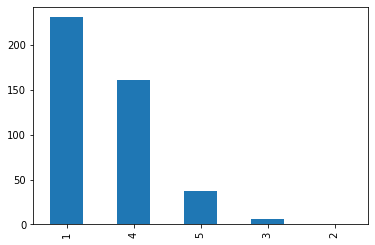

Not used sentence because it bpe len > 64 : 0
Not used sentence because it bpe len > 64 : 0
Training example : 5258
Valid example : 500

======== Epoch 1 / 7 ========
Training...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.35 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



  Average training loss: 0.89
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.62600
  F1: 0.56240
  Validation took: 0:00:00

======== Epoch 2 / 7 ========
Training...

  Average training loss: 0.15
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.65600
  F1: 0.58586
  Validation took: 0:00:00

======== Epoch 3 / 7 ========
Training...

  Average training loss: 0.02
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66000
  F1: 0.58147
  Validation took: 0:00:00

======== Epoch 4 / 7 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66600
  F1: 0.58913
  Validation took: 0:00:00

======== Epoch 5 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66000
  F1: 0.58242
  Validation took: 0:00:00

======== Epoch 6 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0

100%|██████████| 7/7 [00:00<00:00, 45.73it/s]

Not used sentence because it bpe len > 64 : 0
Number of sentence augmentations : 775

Number of augmented samples by Model: 755
Eval examples by model #1



100%|██████████| 7/7 [00:00<00:00, 45.91it/s]

Not used sentence because it bpe len > 64 : 0
Number of sentence augmentations : 775

Number of augmented samples by Model: 711
                                  text  lbl_index
0                 what is " Stelvio "?          1
1           what is obagi action for ?          1
2              What are the deminsions          1
3  can i put it on top of the carpet ?          1
4               does it work on carpet          1 (412, 2)


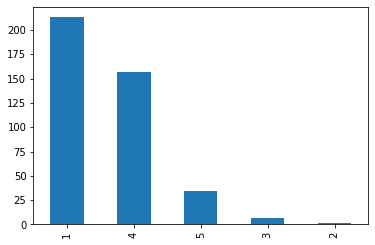

Not used sentence because it bpe len > 64 : 0
Not used sentence because it bpe len > 64 : 0
Training example : 5234
Valid example : 500

======== Epoch 1 / 7 ========
Training...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.35 and num_layers=1
  "num_layers={}".format(dropout, num_layers))



  Average training loss: 0.91
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.64000
  F1: 0.56620
  Validation took: 0:00:00

======== Epoch 2 / 7 ========
Training...

  Average training loss: 0.15
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.62600
  F1: 0.54980
  Validation took: 0:00:00

======== Epoch 3 / 7 ========
Training...

  Average training loss: 0.02
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.66600
  F1: 0.58545
  Validation took: 0:00:00

======== Epoch 4 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.67600
  F1: 0.59467
  Validation took: 0:00:00

======== Epoch 5 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.67600
  F1: 0.59494
  Validation took: 0:00:00

======== Epoch 6 / 7 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0

In [0]:
import matplotlib.pyplot as plt
import torch
tr = train

b = 25000
k = 2
for samples_for_faiss in range(0, len(all_augment_questions), 20000):
  print('####### NEW PART Of DATA ###########')
  part_of_augments = all_augment_questions[samples_for_faiss:samples_for_faiss + b]
  aug_vectors = USE_Embeder(part_of_augments).numpy() 
  distances, indices = get_k_near_neibs(train_vectors, aug_vectors, k)
  samples, labels = filter_samples_by_dist(distances, indices, part_of_augments)
  for indx_train_m, (f1, m_to_train) in enumerate(list(zip(f1_scores, models))):
    print("Index of model to train: {}, Current F1 Score :{}".format(indx_train_m, f1))
    new_saples_from_all_eval_models = []
    for ind_eval_m, m_evaluator in enumerate(models):
      if indx_train_m != ind_eval_m:
        print("Eval examples by model #{}".format(ind_eval_m))
        new_saples_from_all_eval_models.append(bert_proba(0.7, m_evaluator, samples))
    df_merge = pd.merge(new_saples_from_all_eval_models[0], new_saples_from_all_eval_models[1], on=('text',"lbl_index"), how='inner')
    print(df_merge.head(), df_merge.shape)
    df_merge.lbl_index.value_counts().plot(kind='bar')
    plt.show()
    acccur, f1_new, model = train_BertEmbdLSTMPooling(pd.concat([tr, df_merge]), test)
    print("Current F1 Score :{}, NEW F1 score {}".format(f1, f1_new))
    if f1_new > f1 - 0.005:
      models[indx_train_m] = model
      f1_scores[indx_train_m] = f1_new
      tr = pd.concat([tr, df_merge])
      print("########## MODEL updated with f1 score {}. CURRENT TRAIN LEN {} ###############".format(f1_new, len(tr)))
    torch.cuda.empty_cache() 
